In [1]:
!pip install wandb


In [2]:
!wandb login


wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pdev4444 (pdev4444-ai-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
!cp /content/drive/MyDrive/combined/dataset_2.zip /content/

In [4]:
!unzip /content/dataset_2.zip


Archive:  /content/dataset_2.zip
   creating: dataset_2/
  inflating: dataset_2/dataset.yaml  
   creating: dataset_2/test/
   creating: dataset_2/test/images/
  inflating: dataset_2/test/images/alvan-nee-T-0EW-SEbsE-unsplash.jpg  
  inflating: dataset_2/test/images/alvan-nee-ZCHj_2lJP00-unsplash.jpg  
  inflating: dataset_2/test/images/annie-spratt-JMjNnQ2xFoY-unsplash.jpg  
  inflating: dataset_2/test/images/happy-smiling-couple-holding-hands-camera-isolated-white-studio.jpg  
  inflating: dataset_2/test/images/husna-miskandar-FC4z3l4sUYc-unsplash.jpg  
  inflating: dataset_2/test/images/jakob-cotton-UQJf6y91zZs-unsplash.jpg  
  inflating: dataset_2/test/images/jeffery-erhunse-Z9lbmEjyYjU-unsplash.jpg  
  inflating: dataset_2/test/images/lachlan-dempsey-6VPEOdpFNAs-unsplash.jpg  
  inflating: dataset_2/test/images/lloyd-dirks-R1oSj2m-7Ks-unsplash.jpg  
  inflating: dataset_2/test/images/pexels-sharefaith-491036-1231230.jpg  
  inflating: dataset_2/test/images/philcreates-pdALzg0yN-8-

In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [8]:
import os
import wandb
import torch
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from ultralytics import YOLO
import cv2
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class YOLOv8Trainer:
    def __init__(self, data_yaml_path, model_size='n', project_name='yolov8-training'):
        """
        Initialize YOLOv8 trainer with WandB integration

        Args:
            data_yaml_path: Path to data.yaml file
            model_size: YOLOv8 model size ('n', 's', 'm', 'l', 'x')
            project_name: WandB project name
        """
        self.data_yaml_path = data_yaml_path
        self.model_size = model_size
        self.project_name = project_name
        self.model = None
        self.results = None

        # Load data configuration
        with open(data_yaml_path, 'r') as f:
            self.data_config = yaml.safe_load(f)

        # Setup paths
        self.project_dir = Path(f"runs/detect/{project_name}")
        self.project_dir.mkdir(parents=True, exist_ok=True)

    def setup_wandb(self, config=None):
        """Initialize Weights & Biases"""
        default_config = {
            'model_size': self.model_size,
            'dataset': self.data_config.get('path', 'custom'),
            'num_classes': self.data_config.get('nc', len(self.data_config.get('names', []))),
            'class_names': self.data_config.get('names', []),
            'epochs': 100,
            'batch_size': 16,
            'img_size': 640,
            'learning_rate': 0.01,
            'optimizer': 'SGD',
            'patience': 50
        }

        if config:
            default_config.update(config)

        wandb.init(
            project=self.project_name,
            config=default_config,
            name=f"yolov8{self.model_size}-{wandb.util.generate_id()}"
        )

        return wandb.config

    def train(self, epochs=100, img_size=640, batch_size=16, **kwargs):
        """Train YOLOv8 model with WandB logging"""

        # Setup WandB
        config = self.setup_wandb({
            'epochs': epochs,
            'img_size': img_size,
            'batch_size': batch_size,
            **kwargs
        })

        # Initialize model
        model_name = f'yolov8{self.model_size}.pt'
        self.model = YOLO(model_name)

        print(f"Starting training with YOLOv8{self.model_size}")
        print(f"Dataset: {self.data_config.get('path', 'Unknown')}")
        print(f"Classes: {self.data_config.get('names', [])}")

        # Train model with WandB integration
        self.results = self.model.train(
            data=self.data_yaml_path,
            epochs=epochs,
            imgsz=img_size,
            batch=batch_size,
            project=str(self.project_dir.parent),
            name=self.project_name,
            patience=config.patience,
            save_period=10,  # Save checkpoint every 10 epochs
            **kwargs
        )

        # Log model to WandB
        wandb.save(str(self.model.trainer.save_dir / 'weights' / 'best.pt'))
        wandb.save(str(self.model.trainer.save_dir / 'weights' / 'last.pt'))

        return self.results

    def create_training_plots(self):
        """Create comprehensive training visualization plots"""
        if not self.results:
            print("No training results available. Please train the model first.")
            return

        results_df = pd.read_csv(self.model.trainer.csv)

        # Create subplot figure
        fig = make_subplots(
            rows=3, cols=2,
            subplot_titles=(
                'Training & Validation Loss', 'mAP Scores',
                'Precision & Recall', 'Learning Rate',
                'Box Loss Components', 'Class Loss'
            ),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )

        epochs = results_df['epoch']

        # 1. Training & Validation Loss
        fig.add_trace(go.Scatter(x=epochs, y=results_df['train/box_loss'],
                                name='Train Box Loss', line=dict(color='red')), row=1, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['train/cls_loss'],
                                name='Train Class Loss', line=dict(color='orange')), row=1, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['val/box_loss'],
                                name='Val Box Loss', line=dict(color='blue')), row=1, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['val/cls_loss'],
                                name='Val Class Loss', line=dict(color='green')), row=1, col=1)

        # 2. mAP Scores
        fig.add_trace(go.Scatter(x=epochs, y=results_df['metrics/mAP50(B)'],
                                name='mAP@0.5', line=dict(color='purple')), row=1, col=2)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['metrics/mAP50-95(B)'],
                                name='mAP@0.5:0.95', line=dict(color='brown')), row=1, col=2)

        # 3. Precision & Recall
        fig.add_trace(go.Scatter(x=epochs, y=results_df['metrics/precision(B)'],
                                name='Precision', line=dict(color='green')), row=2, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['metrics/recall(B)'],
                                name='Recall', line=dict(color='red')), row=2, col=1)

        # 4. Learning Rate
        fig.add_trace(go.Scatter(x=epochs, y=results_df['lr/pg0'],
                                name='Learning Rate', line=dict(color='black')), row=2, col=2)

        # 5. Box Loss Components
        fig.add_trace(go.Scatter(x=epochs, y=results_df['train/box_loss'],
                                name='Box Loss', line=dict(color='red')), row=3, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['train/dfl_loss'],
                                name='DFL Loss', line=dict(color='orange')), row=3, col=1)

        # 6. Class Loss
        fig.add_trace(go.Scatter(x=epochs, y=results_df['train/cls_loss'],
                                name='Train Class Loss', line=dict(color='blue')), row=3, col=2)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['val/cls_loss'],
                                name='Val Class Loss', line=dict(color='green')), row=3, col=2)

        fig.update_layout(height=1000, title_text="YOLOv8 Training Metrics Dashboard")

        # Save and log to WandB
        fig.write_html(str(self.project_dir / "training_dashboard.html"))
        wandb.log({"training_dashboard": wandb.Html(str(self.project_dir / "training_dashboard.html"))})

        return fig

    def create_confusion_matrix(self, val_data_path=None):
        """Create and visualize confusion matrix"""
        if not self.model:
            print("Model not available. Please train first.")
            return

        # Use validation data from data.yaml if not provided
        if not val_data_path:
            val_data_path = self.data_config.get('val', self.data_config.get('test'))

        if not val_data_path:
            print("No validation data path found.")
            return

        # Run validation
        val_results = self.model.val(data=self.data_yaml_path, split='val')

        # Create confusion matrix plot
        if hasattr(val_results, 'confusion_matrix') and val_results.confusion_matrix is not None:
            cm = val_results.confusion_matrix.matrix
            class_names = self.data_config.get('names', [f'Class_{i}' for i in range(cm.shape[0]-1)])

            # Add background class
            all_classes = class_names + ['Background']

            plt.figure(figsize=(12, 10))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=all_classes, yticklabels=all_classes)
            plt.title('Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()

            # Save and log
            plt.savefig(str(self.project_dir / 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
            wandb.log({"confusion_matrix": wandb.Image(str(self.project_dir / 'confusion_matrix.png'))})
            plt.close()

    def visualize_predictions(self, test_images_path, num_images=10):
        """Visualize model predictions on test images"""
        if not self.model:
            print("Model not available. Please train first.")
            return

        test_path = Path(test_images_path)
        if not test_path.exists():
            print(f"Test images path {test_images_path} does not exist.")
            return

        # Get image files
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        image_files = []
        for ext in image_extensions:
            image_files.extend(list(test_path.glob(f'*{ext}')))
            image_files.extend(list(test_path.glob(f'*{ext.upper()}')))

        # Select random images
        selected_images = np.random.choice(image_files,
                                         min(num_images, len(image_files)),
                                         replace=False)

        prediction_images = []

        for img_path in selected_images:
            # Run prediction
            results = self.model(str(img_path))

            # Plot results
            result_img = results[0].plot()

            # Convert BGR to RGB for display
            result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

            # Save individual prediction
            save_path = self.project_dir / f'prediction_{img_path.stem}.jpg'
            cv2.imwrite(str(save_path), result_img)

            prediction_images.append(wandb.Image(result_img_rgb,
                                               caption=f'Prediction: {img_path.name}'))

        # Log to WandB
        wandb.log({"predictions": prediction_images})

        return prediction_images

    def create_performance_summary(self):
        """Create a comprehensive performance summary"""
        if not self.results:
            print("No training results available.")
            return

        # Get final metrics
        final_metrics = {}
        if hasattr(self.model, 'trainer') and self.model.trainer.csv.exists():
            results_df = pd.read_csv(self.model.trainer.csv)
            last_row = results_df.iloc[-1]

            final_metrics = {
                'Final mAP@0.5': last_row.get('metrics/mAP50(B)', 0),
                'Final mAP@0.5:0.95': last_row.get('metrics/mAP50-95(B)', 0),
                'Final Precision': last_row.get('metrics/precision(B)', 0),
                'Final Recall': last_row.get('metrics/recall(B)', 0),
                'Final Box Loss': last_row.get('val/box_loss', 0),
                'Final Class Loss': last_row.get('val/cls_loss', 0),
                'Total Epochs': int(last_row.get('epoch', 0)) + 1
            }

        # Create summary table
        summary_df = pd.DataFrame(list(final_metrics.items()),
                                columns=['Metric', 'Value'])

        # Create summary plot
        fig = go.Figure(data=[go.Table(
            header=dict(values=['Metric', 'Value'],
                       fill_color='paleturquoise',
                       align='left'),
            cells=dict(values=[summary_df.Metric, summary_df.Value.round(4)],
                      fill_color='lavender',
                      align='left'))
        ])

        fig.update_layout(title="Training Performance Summary")

        # Save and log
        fig.write_html(str(self.project_dir / "performance_summary.html"))
        wandb.log({"performance_summary": wandb.Html(str(self.project_dir / "performance_summary.html"))})
        wandb.log(final_metrics)

        return final_metrics

    def complete_training_pipeline(self, epochs=100, img_size=640, batch_size=16,
                                 test_images_path=None, **kwargs):
        """Complete training pipeline with all visualizations"""
        print("🚀 Starting YOLOv8 Training Pipeline")
        print("=" * 50)

        # 1. Train the model
        print("📊 Training model...")
        self.train(epochs=epochs, img_size=img_size, batch_size=batch_size, **kwargs)

        # 2. Create training plots
        print("📈 Creating training plots...")
        self.create_training_plots()

        # 3. Create confusion matrix
        print("🎯 Generating confusion matrix...")
        self.create_confusion_matrix()

        # 4. Visualize predictions
        if test_images_path:
            print("🖼️ Creating prediction visualizations...")
            self.visualize_predictions(test_images_path)

        # 5. Create performance summary
        print("📋 Generating performance summary...")
        summary = self.create_performance_summary()

        print("✅ Training pipeline completed successfully!")
        print(f"📁 Results saved in: {self.project_dir}")
        print(f"🌐 WandB dashboard: {wandb.run.url}")

        return summary

# Usage example
if __name__ == "__main__":
    # Configuration
    DATA_YAML_PATH = "/content/dataset_2/dataset.yaml"  # Path to your data.yaml file
    MODEL_SIZE = "n"  # Options: 'n', 's', 'm', 'l', 'x'
    PROJECT_NAME = "my-yolov8-project-colab"
    TEST_IMAGES_PATH = "/content/dataset_2/test/images"  # Optional: for prediction visualization

    # Initialize trainer
    trainer = YOLOv8Trainer(
        data_yaml_path=DATA_YAML_PATH,
        model_size=MODEL_SIZE,
        project_name=PROJECT_NAME
    )

    # Run complete training pipeline
    results = trainer.complete_training_pipeline(
        epochs=100,
        img_size=640,
        batch_size=4,
        test_images_path=TEST_IMAGES_PATH,  # Optional
        # Additional training parameters
        patience=50,
        save_period=10,
        device=0,  # GPU device (use 'cpu' for CPU training)
        workers=8,
        optimizer='SGD',
        lr0=0.01,
        momentum=0.937,
        weight_decay=0.0005,
        warmup_epochs=3,
        box=7.5,
        cls=0.5,
        dfl=1.5,
        hsv_h=0.015,
        hsv_s=0.7,
        hsv_v=0.4,
        degrees=0.0,
        translate=0.1,
        scale=0.5,
        shear=0.0,
        perspective=0.0,
        flipud=0.0,
        fliplr=0.5,
        mosaic=1.0,
        mixup=0.0,
        copy_paste=0.0
    )

    # Clean up WandB
    wandb.finish()

    print("Training completed! Check your WandB dashboard for detailed metrics and visualizations.")

🚀 Starting YOLOv8 Training Pipeline
📊 Training model...


wandb: Currently logged in as: pdev4444 (pdev4444-ai-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 6.25M/6.25M [00:00<00:00, 371MB/s]

Starting training with YOLOv8n
Dataset: /content/dataset_2
Classes: ['animals', 'humans']


TypeError: ultralytics.engine.model.Model.train() got multiple values for keyword argument 'patience'

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

🚀 Starting YOLOv8 Training Pipeline
📊 Training model...


Starting training with YOLOv8l
Dataset: /content/dataset_2
Classes: ['animals', 'humans']
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_2/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=900, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=my-yolov8-project-colab-16, nbs=64, nms=False, opset=None, optim

train: Scanning /content/dataset_2/train/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 946.9±1085.5 MB/s, size: 2329.0 KB)


val: Scanning /content/dataset_2/val/labels.cache... 26 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]


Plotting labels to runs/detect/my-yolov8-project-colab-16/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 928 train, 928 val
Using 2 dataloader workers
Logging results to runs/detect/my-yolov8-project-colab-16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.72G      1.685      2.986       2.41         10        928: 100%|██████████| 17/17 [00:18<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all         26         61      0.694       0.66      0.738      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.94G        1.6      1.808      2.138         10        928: 100%|██████████| 17/17 [00:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all         26         61      0.849      0.808      0.894      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.28G      1.605      1.746      2.096         18        928: 100%|██████████| 17/17 [00:11<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all         26         61      0.823      0.836      0.909      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       6.3G      1.499      1.711       1.94          7        928: 100%|██████████| 17/17 [00:19<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


                   all         26         61      0.743      0.866      0.884      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.63G      1.416      1.715      1.846          9        928: 100%|██████████| 17/17 [00:22<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all         26         61      0.673      0.706      0.777      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.63G      1.469      1.548       1.81          9        928: 100%|██████████| 17/17 [00:23<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all         26         61      0.834      0.849      0.921      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.64G      1.418      1.553      1.705          7        928: 100%|██████████| 17/17 [00:26<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all         26         61      0.685      0.866      0.939      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.66G      1.399      1.776      1.763         15        928: 100%|██████████| 17/17 [00:24<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all         26         61      0.857      0.913      0.941      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.99G      1.436      1.317      1.714         12        928: 100%|██████████| 17/17 [00:28<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all         26         61       0.86      0.918      0.942      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.99G      1.379      1.125      1.715         12        928: 100%|██████████| 17/17 [00:33<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all         26         61      0.983      0.859      0.953      0.609


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.99G       1.27      1.024      1.733          4        928: 100%|██████████| 17/17 [00:24<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all         26         61      0.966       0.92      0.969      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.99G      1.356      1.075      1.813          2        928: 100%|██████████| 17/17 [00:12<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all         26         61          1      0.881      0.964      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.99G      1.264     0.8788      1.742          4        928: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all         26         61      0.996      0.915      0.968       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.02G      1.201     0.7743      1.724          3        928: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         26         61      0.962      0.923      0.966      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.02G      1.248     0.7359      1.702          2        928: 100%|██████████| 17/17 [00:19<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all         26         61      0.982        0.9      0.967      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.02G       1.06     0.6868      1.595          5        928: 100%|██████████| 17/17 [00:25<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all         26         61      0.945      0.957      0.971      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.02G      1.154     0.6766      1.696          4        928: 100%|██████████| 17/17 [00:14<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

                   all         26         61       0.95      0.977      0.974      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.04G      1.086     0.6649      1.553          9        928: 100%|██████████| 17/17 [00:24<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


                   all         26         61      0.962      0.978      0.975      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.06G      1.024     0.6416      1.591          6        928: 100%|██████████| 17/17 [00:25<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all         26         61      0.974      0.965      0.975        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.06G      1.115     0.6534       1.66          3        928: 100%|██████████| 17/17 [00:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all         26         61      0.977      0.965      0.974      0.705



20 epochs completed in 0.207 hours.
Optimizer stripped from runs/detect/my-yolov8-project-colab-16/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/my-yolov8-project-colab-16/weights/best.pt, 87.7MB

Validating runs/detect/my-yolov8-project-colab-16/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,608,150 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


                   all         26         61      0.977      0.965      0.974      0.703
               animals         12         23      0.994      0.957      0.956       0.72
                humans         14         38       0.96      0.974      0.991      0.687
Speed: 0.4ms preprocess, 67.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/my-yolov8-project-colab-16
📈 Creating training plots...
🎯 Generating confusion matrix...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,608,150 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3413.7±433.2 MB/s, size: 1798.0 KB)


val: Scanning /content/dataset_2/val/labels.cache... 26 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.90s/it]


                   all         26         61      0.976      0.965      0.974        0.7
               animals         12         23      0.993      0.957      0.956      0.711
                humans         14         38       0.96      0.974      0.991      0.688
Speed: 0.5ms preprocess, 79.3ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/my-yolov8-project-colab-162


ValueError: Unknown format code 'd' for object of type 'float'

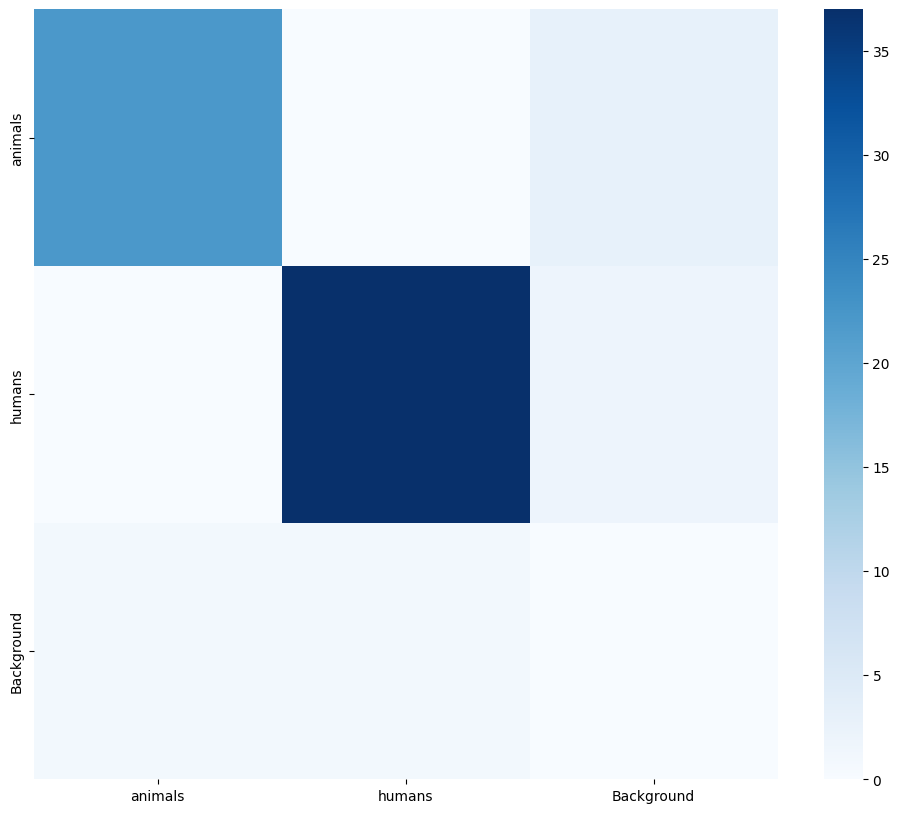

In [14]:
import os
import wandb
import torch
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from ultralytics import YOLO
import cv2
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class YOLOv8Trainer:
    def __init__(self, data_yaml_path, model_size='n', project_name='yolov8-training'):
        """
        Initialize YOLOv8 trainer with WandB integration

        Args:
            data_yaml_path: Path to data.yaml file
            model_size: YOLOv8 model size ('n', 's', 'm', 'l', 'x')
            project_name: WandB project name
        """
        self.data_yaml_path = data_yaml_path
        self.model_size = model_size
        self.project_name = project_name
        self.model = None
        self.results = None

        # Load data configuration
        with open(data_yaml_path, 'r') as f:
            self.data_config = yaml.safe_load(f)

        # Setup paths
        self.project_dir = Path(f"runs/detect/{project_name}")
        self.project_dir.mkdir(parents=True, exist_ok=True)

    def setup_wandb(self, config=None):
        """Initialize Weights & Biases"""
        default_config = {
            'model_size': self.model_size,
            'dataset': self.data_config.get('path', 'custom'),
            'num_classes': self.data_config.get('nc', len(self.data_config.get('names', []))),
            'class_names': self.data_config.get('names', []),
            'epochs': 100,
            'batch_size': 16,
            'img_size': 640,
            'learning_rate': 0.01,
            'optimizer': 'SGD',
            'patience': 50
        }

        if config:
            default_config.update(config)

        wandb.init(
            project=self.project_name,
            config=default_config,
            name=f"yolov8{self.model_size}-{wandb.util.generate_id()}"
        )

        return wandb.config

    def train(self, epochs=100, img_size=640, batch_size=16, **kwargs):
        """Train YOLOv8 model with WandB logging"""

        # Setup WandB
        config = self.setup_wandb({
            'epochs': epochs,
            'img_size': img_size,
            'batch_size': batch_size,
            **kwargs
        })

        # Initialize model
        model_name = f'yolov8{self.model_size}.pt'
        self.model = YOLO(model_name)

        print(f"Starting training with YOLOv8{self.model_size}")
        print(f"Dataset: {self.data_config.get('path', 'Unknown')}")
        print(f"Classes: {self.data_config.get('names', [])}")

        # Prepare training arguments, avoiding conflicts
        train_args = {
            'data': self.data_yaml_path,
            'epochs': epochs,
            'imgsz': img_size,
            'batch': batch_size,
            'project': str(self.project_dir.parent),
            'name': self.project_name,
            'save_period': kwargs.pop('save_period', 10),  # Save checkpoint every 10 epochs
            'patience': kwargs.pop('patience', config.patience),
        }

        # Add remaining kwargs, ensuring no conflicts
        train_args.update(kwargs)

        # Train model with WandB integration
        self.results = self.model.train(**train_args)

        # Log model to WandB
        wandb.save(str(self.model.trainer.save_dir / 'weights' / 'best.pt'))
        wandb.save(str(self.model.trainer.save_dir / 'weights' / 'last.pt'))

        return self.results

    def create_training_plots(self):
        """Create comprehensive training visualization plots"""
        if not self.results:
            print("No training results available. Please train the model first.")
            return

        results_df = pd.read_csv(self.model.trainer.csv)

        # Create subplot figure
        fig = make_subplots(
            rows=3, cols=2,
            subplot_titles=(
                'Training & Validation Loss', 'mAP Scores',
                'Precision & Recall', 'Learning Rate',
                'Box Loss Components', 'Class Loss'
            ),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )

        epochs = results_df['epoch']

        # 1. Training & Validation Loss
        fig.add_trace(go.Scatter(x=epochs, y=results_df['train/box_loss'],
                                name='Train Box Loss', line=dict(color='red')), row=1, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['train/cls_loss'],
                                name='Train Class Loss', line=dict(color='orange')), row=1, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['val/box_loss'],
                                name='Val Box Loss', line=dict(color='blue')), row=1, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['val/cls_loss'],
                                name='Val Class Loss', line=dict(color='green')), row=1, col=1)

        # 2. mAP Scores
        fig.add_trace(go.Scatter(x=epochs, y=results_df['metrics/mAP50(B)'],
                                name='mAP@0.5', line=dict(color='purple')), row=1, col=2)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['metrics/mAP50-95(B)'],
                                name='mAP@0.5:0.95', line=dict(color='brown')), row=1, col=2)

        # 3. Precision & Recall
        fig.add_trace(go.Scatter(x=epochs, y=results_df['metrics/precision(B)'],
                                name='Precision', line=dict(color='green')), row=2, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['metrics/recall(B)'],
                                name='Recall', line=dict(color='red')), row=2, col=1)

        # 4. Learning Rate
        fig.add_trace(go.Scatter(x=epochs, y=results_df['lr/pg0'],
                                name='Learning Rate', line=dict(color='black')), row=2, col=2)

        # 5. Box Loss Components
        fig.add_trace(go.Scatter(x=epochs, y=results_df['train/box_loss'],
                                name='Box Loss', line=dict(color='red')), row=3, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['train/dfl_loss'],
                                name='DFL Loss', line=dict(color='orange')), row=3, col=1)

        # 6. Class Loss
        fig.add_trace(go.Scatter(x=epochs, y=results_df['train/cls_loss'],
                                name='Train Class Loss', line=dict(color='blue')), row=3, col=2)
        fig.add_trace(go.Scatter(x=epochs, y=results_df['val/cls_loss'],
                                name='Val Class Loss', line=dict(color='green')), row=3, col=2)

        fig.update_layout(height=1000, title_text="YOLOv8 Training Metrics Dashboard")

        # Save and log to WandB
        fig.write_html(str(self.project_dir / "training_dashboard.html"))
        wandb.log({"training_dashboard": wandb.Html(str(self.project_dir / "training_dashboard.html"))})

        return fig

    def create_confusion_matrix(self, val_data_path=None):
        """Create and visualize confusion matrix"""
        if not self.model:
            print("Model not available. Please train first.")
            return

        # Use validation data from data.yaml if not provided
        if not val_data_path:
            val_data_path = self.data_config.get('val', self.data_config.get('test'))

        if not val_data_path:
            print("No validation data path found.")
            return

        # Run validation
        val_results = self.model.val(data=self.data_yaml_path, split='val')

        # Create confusion matrix plot
        if hasattr(val_results, 'confusion_matrix') and val_results.confusion_matrix is not None:
            cm = val_results.confusion_matrix.matrix
            class_names = self.data_config.get('names', [f'Class_{i}' for i in range(cm.shape[0]-1)])

            # Add background class
            all_classes = class_names + ['Background']

            plt.figure(figsize=(12, 10))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=all_classes, yticklabels=all_classes)
            plt.title('Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()

            # Save and log
            plt.savefig(str(self.project_dir / 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
            wandb.log({"confusion_matrix": wandb.Image(str(self.project_dir / 'confusion_matrix.png'))})
            plt.close()

    def visualize_predictions(self, test_images_path, num_images=10):
        """Visualize model predictions on test images"""
        if not self.model:
            print("Model not available. Please train first.")
            return

        test_path = Path(test_images_path)
        if not test_path.exists():
            print(f"Test images path {test_images_path} does not exist.")
            return

        # Get image files
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        image_files = []
        for ext in image_extensions:
            image_files.extend(list(test_path.glob(f'*{ext}')))
            image_files.extend(list(test_path.glob(f'*{ext.upper()}')))

        # Select random images
        selected_images = np.random.choice(image_files,
                                         min(num_images, len(image_files)),
                                         replace=False)

        prediction_images = []

        for img_path in selected_images:
            # Run prediction
            results = self.model(str(img_path))

            # Plot results
            result_img = results[0].plot()

            # Convert BGR to RGB for display
            result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

            # Save individual prediction
            save_path = self.project_dir / f'prediction_{img_path.stem}.jpg'
            cv2.imwrite(str(save_path), result_img)

            prediction_images.append(wandb.Image(result_img_rgb,
                                               caption=f'Prediction: {img_path.name}'))

        # Log to WandB
        wandb.log({"predictions": prediction_images})

        return prediction_images

    def create_performance_summary(self):
        """Create a comprehensive performance summary"""
        if not self.results:
            print("No training results available.")
            return

        # Get final metrics
        final_metrics = {}
        if hasattr(self.model, 'trainer') and self.model.trainer.csv.exists():
            results_df = pd.read_csv(self.model.trainer.csv)
            last_row = results_df.iloc[-1]

            final_metrics = {
                'Final mAP@0.5': last_row.get('metrics/mAP50(B)', 0),
                'Final mAP@0.5:0.95': last_row.get('metrics/mAP50-95(B)', 0),
                'Final Precision': last_row.get('metrics/precision(B)', 0),
                'Final Recall': last_row.get('metrics/recall(B)', 0),
                'Final Box Loss': last_row.get('val/box_loss', 0),
                'Final Class Loss': last_row.get('val/cls_loss', 0),
                'Total Epochs': int(last_row.get('epoch', 0)) + 1
            }

        # Create summary table
        summary_df = pd.DataFrame(list(final_metrics.items()),
                                columns=['Metric', 'Value'])

        # Create summary plot
        fig = go.Figure(data=[go.Table(
            header=dict(values=['Metric', 'Value'],
                       fill_color='paleturquoise',
                       align='left'),
            cells=dict(values=[summary_df.Metric, summary_df.Value.round(4)],
                      fill_color='lavender',
                      align='left'))
        ])

        fig.update_layout(title="Training Performance Summary")

        # Save and log
        fig.write_html(str(self.project_dir / "performance_summary.html"))
        wandb.log({"performance_summary": wandb.Html(str(self.project_dir / "performance_summary.html"))})
        wandb.log(final_metrics)

        return final_metrics

    def complete_training_pipeline(self, epochs=100, img_size=640, batch_size=16,
                                 test_images_path=None, **kwargs):
        """Complete training pipeline with all visualizations"""
        print("🚀 Starting YOLOv8 Training Pipeline")
        print("=" * 50)

        # 1. Train the model
        print("📊 Training model...")
        self.train(epochs=epochs, img_size=img_size, batch_size=batch_size, **kwargs)

        # 2. Create training plots
        print("📈 Creating training plots...")
        self.create_training_plots()

        # 3. Create confusion matrix
        print("🎯 Generating confusion matrix...")
        self.create_confusion_matrix()

        # 4. Visualize predictions
        if test_images_path:
            print("🖼️ Creating prediction visualizations...")
            self.visualize_predictions(test_images_path)

        # 5. Create performance summary
        print("📋 Generating performance summary...")
        summary = self.create_performance_summary()

        print("✅ Training pipeline completed successfully!")
        print(f"📁 Results saved in: {self.project_dir}")
        print(f"🌐 WandB dashboard: {wandb.run.url}")

        return summary

# Usage example
if __name__ == "__main__":
    # Configuration
    DATA_YAML_PATH = "/content/dataset_2/dataset.yaml"  # Path to your data.yaml file
    MODEL_SIZE = "l"  # Options: 'n', 's', 'm', 'l', 'x'
    PROJECT_NAME = "my-yolov8-project-colab-1"
    TEST_IMAGES_PATH = "/content/dataset_2/test/images"  # Optional: for prediction visualization

    # Initialize trainer
    trainer = YOLOv8Trainer(
        data_yaml_path=DATA_YAML_PATH,
        model_size=MODEL_SIZE,
        project_name=PROJECT_NAME
    )

    # Run complete training pipeline
    results = trainer.complete_training_pipeline(
        epochs=20,
        img_size=900,
        batch_size=4,
        test_images_path=TEST_IMAGES_PATH,  # Optional
        # Additional training parameters (these will be properly handled)
        patience=15,
        save_period=10,
        device=0,  # GPU device (use 'cpu' for CPU training)
        workers=8,
        optimizer='SGD',
        lr0=0.01,
        momentum=0.937,
        weight_decay=0.0005,
        warmup_epochs=3,
        box=7.5,
        cls=0.5,
        dfl=1.5,
        hsv_h=0.015,
        hsv_s=0.7,
        hsv_v=0.4,
        degrees=0.0,
        translate=0.1,
        scale=0.5,
        shear=0.0,
        perspective=0.0,
        flipud=0.0,
        fliplr=0.5,
        mosaic=1.0,
        mixup=0.0,
        copy_paste=0.0
    )

    # Clean up WandB
    wandb.finish()

    print("Training completed! Check your WandB dashboard for detailed metrics and visualizations.")

Loading model from: /content/runs/detect/my-yolov8-project-colab-16/weights/best.pt
Model loaded successfully!
Classes: ['animals', 'humans']
Device: cpu
Processing image: /content/images (1).jpg

0: 640x928 1 humans, 85.6ms
Speed: 10.6ms preprocess, 85.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 928)
Annotated image saved: inference_results/images (1)_detected.jpg


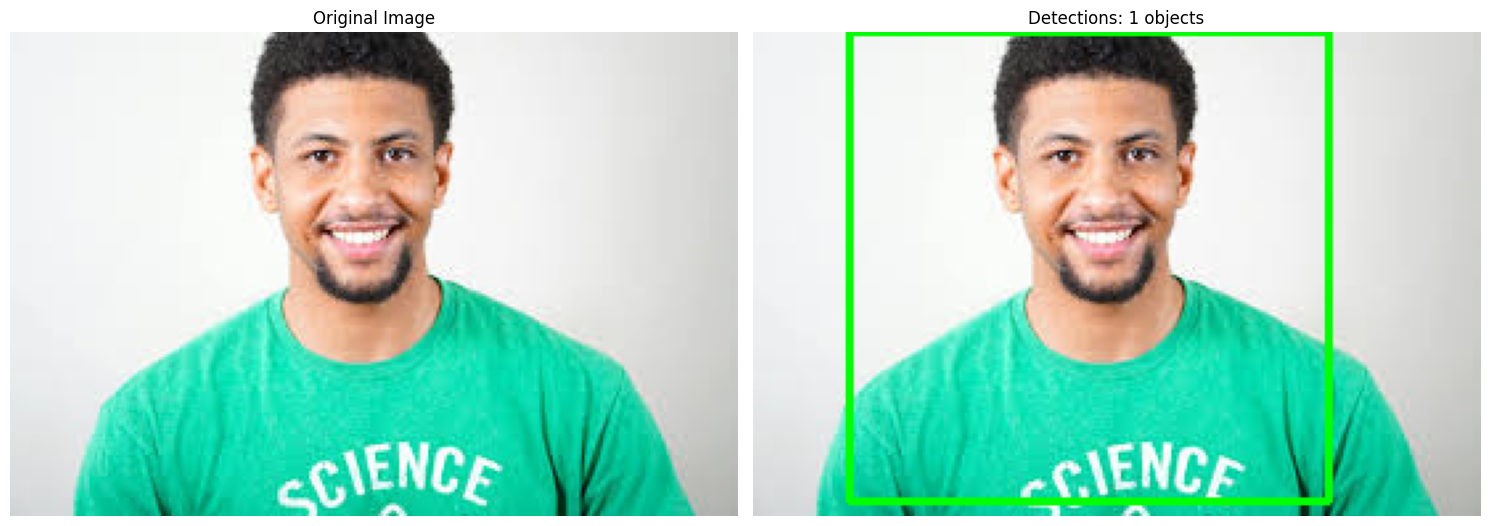

Found 1 objects in 1.420s


usage: colab_kernel_launcher.py [-h] --model MODEL --source SOURCE
                                [--conf CONF] [--iou IOU] [--device DEVICE]
                                [--save] [--show] [--json] [--output OUTPUT]
colab_kernel_launcher.py: error: the following arguments are required: --model, --source


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [15]:
import os
import cv2
import torch
import numpy as np
import argparse
from pathlib import Path
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import json
from typing import List, Dict, Tuple, Union
import time
from datetime import datetime

class YOLOv8Inference:
    def __init__(self, model_path: str, conf_threshold: float = 0.25,
                 iou_threshold: float = 0.45, device: str = 'auto'):
        """
        Initialize YOLOv8 inference class

        Args:
            model_path: Path to trained model weights (.pt file)
            conf_threshold: Confidence threshold for detections
            iou_threshold: IoU threshold for NMS
            device: Device to run inference on ('auto', 'cpu', 'cuda', '0', '1', etc.)
        """
        self.model_path = model_path
        self.conf_threshold = conf_threshold
        self.iou_threshold = iou_threshold
        self.device = device

        # Load model
        print(f"Loading model from: {model_path}")
        self.model = YOLO(model_path)

        # Get class names
        self.class_names = self.model.names
        print(f"Model loaded successfully!")
        print(f"Classes: {list(self.class_names.values())}")
        print(f"Device: {self.model.device}")

        # Create output directory
        self.output_dir = Path("inference_results")
        self.output_dir.mkdir(exist_ok=True)

    def preprocess_image(self, image_path: str) -> np.ndarray:
        """Load and preprocess image"""
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not load image from {image_path}")
        else:
            image = image_path
        return image

    def draw_detections(self, image: np.ndarray, results,
                       show_conf: bool = True, show_labels: bool = True) -> np.ndarray:
        """Draw bounding boxes and labels on image"""
        annotated_image = image.copy()

        # Get detection results
        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2
            confidences = results[0].boxes.conf.cpu().numpy()
            class_ids = results[0].boxes.cls.cpu().numpy().astype(int)

            # Define colors for different classes
            colors = [
                (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255),
                (0, 255, 255), (128, 0, 128), (255, 165, 0), (255, 192, 203), (0, 128, 0)
            ]

            for i, (box, conf, class_id) in enumerate(zip(boxes, confidences, class_ids)):
                if conf >= self.conf_threshold:
                    x1, y1, x2, y2 = map(int, box)

                    # Get color for this class
                    color = colors[class_id % len(colors)]

                    # Draw bounding box
                    cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)

                    # Prepare label
                    label_parts = []
                    if show_labels:
                        label_parts.append(self.class_names[class_id])
                    if show_conf:
                        label_parts.append(f"{conf:.2f}")

                    if label_parts:
                        label = " - ".join(label_parts)

                        # Calculate text size
                        font_scale = 0.6
                        thickness = 2
                        (text_width, text_height), baseline = cv2.getTextSize(
                            label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
                        )

                        # Draw label background
                        cv2.rectangle(annotated_image,
                                    (x1, y1 - text_height - baseline - 5),
                                    (x1 + text_width, y1), color, -1)

                        # Draw label text
                        cv2.putText(annotated_image, label, (x1, y1 - baseline - 5),
                                  cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

        return annotated_image

    def extract_detections_info(self, results) -> List[Dict]:
        """Extract detection information as structured data"""
        detections = []

        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            confidences = results[0].boxes.conf.cpu().numpy()
            class_ids = results[0].boxes.cls.cpu().numpy().astype(int)

            for i, (box, conf, class_id) in enumerate(zip(boxes, confidences, class_ids)):
                if conf >= self.conf_threshold:
                    x1, y1, x2, y2 = box
                    detection = {
                        'class_id': int(class_id),
                        'class_name': self.class_names[class_id],
                        'confidence': float(conf),
                        'bbox': {
                            'x1': float(x1), 'y1': float(y1),
                            'x2': float(x2), 'y2': float(y2)
                        },
                        'center': {
                            'x': float((x1 + x2) / 2),
                            'y': float((y1 + y2) / 2)
                        },
                        'area': float((x2 - x1) * (y2 - y1))
                    }
                    detections.append(detection)

        return detections

    def infer_image(self, image_path: str, save_result: bool = True,
                   show_result: bool = False, save_json: bool = False) -> Dict:
        """
        Run inference on a single image

        Args:
            image_path: Path to input image
            save_result: Save annotated image
            show_result: Display result using matplotlib
            save_json: Save detection results as JSON

        Returns:
            Dictionary containing results and metadata
        """
        print(f"Processing image: {image_path}")

        # Load image
        image = self.preprocess_image(image_path)
        original_shape = image.shape[:2]

        # Run inference
        start_time = time.time()
        results = self.model(image, conf=self.conf_threshold, iou=self.iou_threshold)
        inference_time = time.time() - start_time

        # Extract detections
        detections = self.extract_detections_info(results)

        # Draw annotations
        annotated_image = self.draw_detections(image, results)

        # Prepare results
        result_data = {
            'image_path': str(image_path),
            'image_shape': {'height': original_shape[0], 'width': original_shape[1]},
            'inference_time': inference_time,
            'detections_count': len(detections),
            'detections': detections,
            'timestamp': datetime.now().isoformat()
        }

        # Save annotated image
        if save_result:
            image_name = Path(image_path).stem
            output_path = self.output_dir / f"{image_name}_detected.jpg"
            cv2.imwrite(str(output_path), annotated_image)
            result_data['output_image_path'] = str(output_path)
            print(f"Annotated image saved: {output_path}")

        # Save JSON results
        if save_json:
            json_path = self.output_dir / f"{Path(image_path).stem}_results.json"
            with open(json_path, 'w') as f:
                json.dump(result_data, f, indent=2)
            result_data['json_path'] = str(json_path)
            print(f"Results saved: {json_path}")

        # Display result
        if show_result:
            plt.figure(figsize=(15, 10))

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            plt.title(f'Detections: {len(detections)} objects')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        print(f"Found {len(detections)} objects in {inference_time:.3f}s")
        return result_data

    def infer_video(self, video_path: str, output_path: str = None,
                   save_frames: bool = False, frame_skip: int = 1) -> Dict:
        """
        Run inference on video

        Args:
            video_path: Path to input video
            output_path: Path for output video (optional)
            save_frames: Save individual frames with detections
            frame_skip: Process every nth frame (1 = all frames)

        Returns:
            Dictionary containing results and metadata
        """
        print(f"Processing video: {video_path}")

        # Open video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"Video info: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frames")

        # Setup output video writer
        if output_path is None:
            video_name = Path(video_path).stem
            output_path = self.output_dir / f"{video_name}_detected.mp4"

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))

        # Setup frame saving directory
        if save_frames:
            frames_dir = self.output_dir / f"{Path(video_path).stem}_frames"
            frames_dir.mkdir(exist_ok=True)

        # Process video
        frame_count = 0
        processed_frames = 0
        total_detections = 0
        processing_times = []

        print("Processing video frames...")
        start_time = time.time()

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Skip frames if specified
            if frame_count % frame_skip != 0:
                frame_count += 1
                out.write(frame)  # Write original frame
                continue

            # Run inference
            frame_start = time.time()
            results = self.model(frame, conf=self.conf_threshold, iou=self.iou_threshold)
            inference_time = time.time() - frame_start
            processing_times.append(inference_time)

            # Draw detections
            annotated_frame = self.draw_detections(frame, results)

            # Count detections
            detections = self.extract_detections_info(results)
            total_detections += len(detections)

            # Write frame to output video
            out.write(annotated_frame)

            # Save frame if requested
            if save_frames and len(detections) > 0:
                frame_filename = frames_dir / f"frame_{frame_count:06d}.jpg"
                cv2.imwrite(str(frame_filename), annotated_frame)

            processed_frames += 1
            frame_count += 1

            # Progress update
            if frame_count % 30 == 0:
                progress = (frame_count / total_frames) * 100
                avg_time = np.mean(processing_times[-30:])
                print(f"Progress: {progress:.1f}% ({frame_count}/{total_frames}) - "
                      f"Avg inference: {avg_time:.3f}s/frame")

        # Cleanup
        cap.release()
        out.release()

        total_time = time.time() - start_time

        # Prepare results
        result_data = {
            'video_path': str(video_path),
            'output_path': str(output_path),
            'video_info': {
                'width': frame_width,
                'height': frame_height,
                'fps': fps,
                'total_frames': total_frames,
                'processed_frames': processed_frames
            },
            'processing_stats': {
                'total_time': total_time,
                'avg_inference_time': np.mean(processing_times),
                'fps_processed': processed_frames / total_time,
                'total_detections': total_detections,
                'avg_detections_per_frame': total_detections / processed_frames if processed_frames > 0 else 0
            },
            'timestamp': datetime.now().isoformat()
        }

        print(f"Video processing completed!")
        print(f"Output saved: {output_path}")
        print(f"Total time: {total_time:.2f}s")
        print(f"Average inference time: {np.mean(processing_times):.3f}s per frame")
        print(f"Processing FPS: {processed_frames / total_time:.2f}")
        print(f"Total detections: {total_detections}")

        return result_data

    def infer_batch_images(self, images_dir: str, pattern: str = "*.jpg") -> List[Dict]:
        """
        Run inference on batch of images

        Args:
            images_dir: Directory containing images
            pattern: File pattern to match (e.g., "*.jpg", "*.png")

        Returns:
            List of result dictionaries
        """
        images_path = Path(images_dir)
        image_files = list(images_path.glob(pattern))

        if not image_files:
            print(f"No images found in {images_dir} matching pattern {pattern}")
            return []

        print(f"Found {len(image_files)} images to process")

        results = []
        for i, image_file in enumerate(image_files):
            print(f"Processing {i+1}/{len(image_files)}: {image_file.name}")
            result = self.infer_image(str(image_file), save_result=True, save_json=False)
            results.append(result)

        # Save batch results
        batch_results = {
            'batch_info': {
                'images_dir': str(images_dir),
                'pattern': pattern,
                'total_images': len(image_files),
                'total_detections': sum(r['detections_count'] for r in results)
            },
            'results': results,
            'timestamp': datetime.now().isoformat()
        }

        batch_json_path = self.output_dir / f"batch_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        with open(batch_json_path, 'w') as f:
            json.dump(batch_results, f, indent=2)

        print(f"Batch results saved: {batch_json_path}")
        return results

    def real_time_webcam(self, camera_index: int = 0, display_fps: bool = True):
        """
        Real-time inference from webcam

        Args:
            camera_index: Camera device index (0 for default)
            display_fps: Show FPS on screen
        """
        cap = cv2.VideoCapture(camera_index)
        if not cap.isOpened():
            raise ValueError(f"Could not open camera {camera_index}")

        print("Starting real-time inference. Press 'q' to quit, 's' to save current frame")

        fps_counter = 0
        fps_timer = time.time()
        fps_display = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Run inference
            start_time = time.time()
            results = self.model(frame, conf=self.conf_threshold, iou=self.iou_threshold)
            inference_time = time.time() - start_time

            # Draw detections
            annotated_frame = self.draw_detections(frame, results)

            # Calculate and display FPS
            fps_counter += 1
            if time.time() - fps_timer >= 1.0:
                fps_display = fps_counter
                fps_counter = 0
                fps_timer = time.time()

            if display_fps:
                cv2.putText(annotated_frame, f"FPS: {fps_display}", (10, 30),
                          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.putText(annotated_frame, f"Inference: {inference_time:.3f}s", (10, 70),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            # Display frame
            cv2.imshow('YOLOv8 Real-time Detection', annotated_frame)

            # Handle key presses
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('s'):
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                save_path = self.output_dir / f"webcam_capture_{timestamp}.jpg"
                cv2.imwrite(str(save_path), annotated_frame)
                print(f"Frame saved: {save_path}")

        cap.release()
        cv2.destroyAllWindows()


def main():
    parser = argparse.ArgumentParser(description='YOLOv8 Inference Script')
    parser.add_argument('--model', required=True, help='Path to trained model (.pt file)')
    parser.add_argument('--source', required=True, help='Source: image file, video file, directory, or webcam (0)')
    parser.add_argument('--conf', type=float, default=0.25, help='Confidence threshold')
    parser.add_argument('--iou', type=float, default=0.45, help='IoU threshold for NMS')
    parser.add_argument('--device', default='auto', help='Device to run on')
    parser.add_argument('--save', action='store_true', help='Save results')
    parser.add_argument('--show', action='store_true', help='Show results')
    parser.add_argument('--json', action='store_true', help='Save JSON results')
    parser.add_argument('--output', help='Output path for video')

    args = parser.parse_args()

    # Initialize inference
    inference = YOLOv8Inference(
        model_path=args.model,
        conf_threshold=args.conf,
        iou_threshold=args.iou,
        device=args.device
    )

    # Determine source type and run inference
    source = args.source

    if source.isdigit() or source.lower() == 'webcam':
        # Webcam
        camera_index = int(source) if source.isdigit() else 0
        inference.real_time_webcam(camera_index)

    elif Path(source).is_file():
        # Single file
        if source.lower().endswith(('.mp4', '.avi', '.mov', '.mkv', '.wmv')):
            # Video file
            inference.infer_video(source, args.output, save_frames=args.save)
        else:
            # Image file
            inference.infer_image(source, args.save, args.show, args.json)

    elif Path(source).is_dir():
        # Directory of images
        inference.infer_batch_images(source)

    else:
        print(f"Invalid source: {source}")
        print("Source can be:")
        print("- Image file path")
        print("- Video file path")
        print("- Directory path")
        print("- Camera index (0, 1, 2, etc.)")
        print("- 'webcam' for default camera")


if __name__ == "__main__":
    # Example usage without command line arguments
    # Uncomment and modify as needed

    MODEL_PATH = "/content/runs/detect/my-yolov8-project-colab-16/weights/best.pt"  # Path to your trained model
    #
    inference = YOLOv8Inference(
       model_path=MODEL_PATH,
       conf_threshold=0.25,
       iou_threshold=0.45
     )
    #
    # # Image inference
    inference.infer_image("/content/images (1).jpg", save_result=True, show_result=True)
    #
    # # Video inference
    # inference.infer_video("test_video.mp4", "output_video.mp4")
    #
    # # Batch inference
    # inference.infer_batch_images("test_images/")
    #
    # # Real-time webcam
    # inference.real_time_webcam(0)

    main()

Loading model from: /content/runs/detect/my-yolov8-project-colab-16/weights/best.pt
Model loaded successfully!
Classes: ['animals', 'humans']
Device: cpu
Processing image: /content/images (2).jpg

0: 544x928 1 animals, 113.5ms
Speed: 4.5ms preprocess, 113.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 928)
Annotated image saved: inference_results/images (2)_detected.jpg


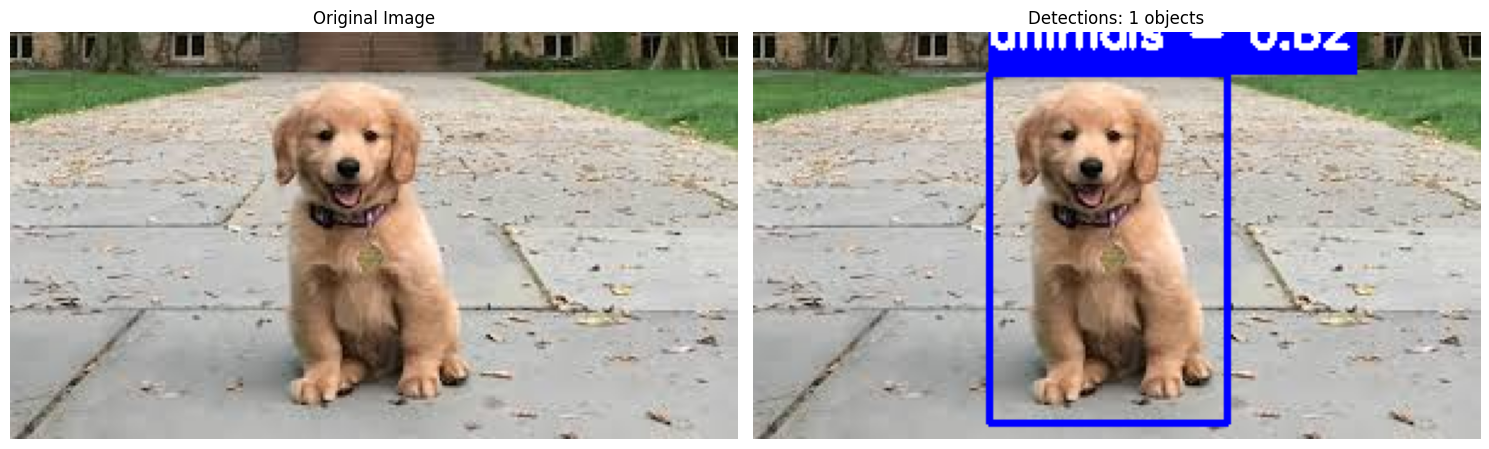

Found 1 objects in 1.707s


usage: colab_kernel_launcher.py [-h] --model MODEL --source SOURCE
                                [--conf CONF] [--iou IOU] [--device DEVICE]
                                [--save] [--show] [--json] [--output OUTPUT]
colab_kernel_launcher.py: error: the following arguments are required: --model, --source


SystemExit: 2

In [16]:
import os
import cv2
import torch
import numpy as np
import argparse
from pathlib import Path
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import json
from typing import List, Dict, Tuple, Union
import time
from datetime import datetime

class YOLOv8Inference:
    def __init__(self, model_path: str, conf_threshold: float = 0.25,
                 iou_threshold: float = 0.45, device: str = 'auto'):
        """
        Initialize YOLOv8 inference class

        Args:
            model_path: Path to trained model weights (.pt file)
            conf_threshold: Confidence threshold for detections
            iou_threshold: IoU threshold for NMS
            device: Device to run inference on ('auto', 'cpu', 'cuda', '0', '1', etc.)
        """
        self.model_path = model_path
        self.conf_threshold = conf_threshold
        self.iou_threshold = iou_threshold
        self.device = device

        # Load model
        print(f"Loading model from: {model_path}")
        self.model = YOLO(model_path)

        # Get class names
        self.class_names = self.model.names
        print(f"Model loaded successfully!")
        print(f"Classes: {list(self.class_names.values())}")
        print(f"Device: {self.model.device}")

        # Create output directory
        self.output_dir = Path("inference_results")
        self.output_dir.mkdir(exist_ok=True)

    def preprocess_image(self, image_path: str) -> np.ndarray:
        """Load and preprocess image"""
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not load image from {image_path}")
        else:
            image = image_path
        return image

    def draw_detections(self, image: np.ndarray, results,
                       show_conf: bool = True, show_labels: bool = True) -> np.ndarray:
        """Draw bounding boxes and labels on image"""
        annotated_image = image.copy()

        # Get detection results
        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2
            confidences = results[0].boxes.conf.cpu().numpy()
            class_ids = results[0].boxes.cls.cpu().numpy().astype(int)

            # Define colors for different classes
            colors = [
                (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255),
                (0, 255, 255), (128, 0, 128), (255, 165, 0), (255, 192, 203), (0, 128, 0)
            ]

            for i, (box, conf, class_id) in enumerate(zip(boxes, confidences, class_ids)):
                if conf >= self.conf_threshold:
                    x1, y1, x2, y2 = map(int, box)

                    # Get color for this class
                    color = colors[class_id % len(colors)]

                    # Draw bounding box
                    cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)

                    # Prepare label
                    label_parts = []
                    if show_labels:
                        label_parts.append(self.class_names[class_id])
                    if show_conf:
                        label_parts.append(f"{conf:.2f}")

                    if label_parts:
                        label = " - ".join(label_parts)

                        # Calculate text size
                        font_scale = 0.6
                        thickness = 2
                        (text_width, text_height), baseline = cv2.getTextSize(
                            label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
                        )

                        # Draw label background
                        cv2.rectangle(annotated_image,
                                    (x1, y1 - text_height - baseline - 5),
                                    (x1 + text_width, y1), color, -1)

                        # Draw label text
                        cv2.putText(annotated_image, label, (x1, y1 - baseline - 5),
                                  cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

        return annotated_image

    def extract_detections_info(self, results) -> List[Dict]:
        """Extract detection information as structured data"""
        detections = []

        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            confidences = results[0].boxes.conf.cpu().numpy()
            class_ids = results[0].boxes.cls.cpu().numpy().astype(int)

            for i, (box, conf, class_id) in enumerate(zip(boxes, confidences, class_ids)):
                if conf >= self.conf_threshold:
                    x1, y1, x2, y2 = box
                    detection = {
                        'class_id': int(class_id),
                        'class_name': self.class_names[class_id],
                        'confidence': float(conf),
                        'bbox': {
                            'x1': float(x1), 'y1': float(y1),
                            'x2': float(x2), 'y2': float(y2)
                        },
                        'center': {
                            'x': float((x1 + x2) / 2),
                            'y': float((y1 + y2) / 2)
                        },
                        'area': float((x2 - x1) * (y2 - y1))
                    }
                    detections.append(detection)

        return detections

    def infer_image(self, image_path: str, save_result: bool = True,
                   show_result: bool = False, save_json: bool = False) -> Dict:
        """
        Run inference on a single image

        Args:
            image_path: Path to input image
            save_result: Save annotated image
            show_result: Display result using matplotlib
            save_json: Save detection results as JSON

        Returns:
            Dictionary containing results and metadata
        """
        print(f"Processing image: {image_path}")

        # Load image
        image = self.preprocess_image(image_path)
        original_shape = image.shape[:2]

        # Run inference
        start_time = time.time()
        results = self.model(image, conf=self.conf_threshold, iou=self.iou_threshold)
        inference_time = time.time() - start_time

        # Extract detections
        detections = self.extract_detections_info(results)

        # Draw annotations
        annotated_image = self.draw_detections(image, results)

        # Prepare results
        result_data = {
            'image_path': str(image_path),
            'image_shape': {'height': original_shape[0], 'width': original_shape[1]},
            'inference_time': inference_time,
            'detections_count': len(detections),
            'detections': detections,
            'timestamp': datetime.now().isoformat()
        }

        # Save annotated image
        if save_result:
            image_name = Path(image_path).stem
            output_path = self.output_dir / f"{image_name}_detected.jpg"
            cv2.imwrite(str(output_path), annotated_image)
            result_data['output_image_path'] = str(output_path)
            print(f"Annotated image saved: {output_path}")

        # Save JSON results
        if save_json:
            json_path = self.output_dir / f"{Path(image_path).stem}_results.json"
            with open(json_path, 'w') as f:
                json.dump(result_data, f, indent=2)
            result_data['json_path'] = str(json_path)
            print(f"Results saved: {json_path}")

        # Display result
        if show_result:
            plt.figure(figsize=(15, 10))

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            plt.title(f'Detections: {len(detections)} objects')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        print(f"Found {len(detections)} objects in {inference_time:.3f}s")
        return result_data

    def infer_video(self, video_path: str, output_path: str = None,
                   save_frames: bool = False, frame_skip: int = 1) -> Dict:
        """
        Run inference on video

        Args:
            video_path: Path to input video
            output_path: Path for output video (optional)
            save_frames: Save individual frames with detections
            frame_skip: Process every nth frame (1 = all frames)

        Returns:
            Dictionary containing results and metadata
        """
        print(f"Processing video: {video_path}")

        # Open video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"Video info: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frames")

        # Setup output video writer
        if output_path is None:
            video_name = Path(video_path).stem
            output_path = self.output_dir / f"{video_name}_detected.mp4"

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))

        # Setup frame saving directory
        if save_frames:
            frames_dir = self.output_dir / f"{Path(video_path).stem}_frames"
            frames_dir.mkdir(exist_ok=True)

        # Process video
        frame_count = 0
        processed_frames = 0
        total_detections = 0
        processing_times = []

        print("Processing video frames...")
        start_time = time.time()

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Skip frames if specified
            if frame_count % frame_skip != 0:
                frame_count += 1
                out.write(frame)  # Write original frame
                continue

            # Run inference
            frame_start = time.time()
            results = self.model(frame, conf=self.conf_threshold, iou=self.iou_threshold)
            inference_time = time.time() - frame_start
            processing_times.append(inference_time)

            # Draw detections
            annotated_frame = self.draw_detections(frame, results)

            # Count detections
            detections = self.extract_detections_info(results)
            total_detections += len(detections)

            # Write frame to output video
            out.write(annotated_frame)

            # Save frame if requested
            if save_frames and len(detections) > 0:
                frame_filename = frames_dir / f"frame_{frame_count:06d}.jpg"
                cv2.imwrite(str(frame_filename), annotated_frame)

            processed_frames += 1
            frame_count += 1

            # Progress update
            if frame_count % 30 == 0:
                progress = (frame_count / total_frames) * 100
                avg_time = np.mean(processing_times[-30:])
                print(f"Progress: {progress:.1f}% ({frame_count}/{total_frames}) - "
                      f"Avg inference: {avg_time:.3f}s/frame")

        # Cleanup
        cap.release()
        out.release()

        total_time = time.time() - start_time

        # Prepare results
        result_data = {
            'video_path': str(video_path),
            'output_path': str(output_path),
            'video_info': {
                'width': frame_width,
                'height': frame_height,
                'fps': fps,
                'total_frames': total_frames,
                'processed_frames': processed_frames
            },
            'processing_stats': {
                'total_time': total_time,
                'avg_inference_time': np.mean(processing_times),
                'fps_processed': processed_frames / total_time,
                'total_detections': total_detections,
                'avg_detections_per_frame': total_detections / processed_frames if processed_frames > 0 else 0
            },
            'timestamp': datetime.now().isoformat()
        }

        print(f"Video processing completed!")
        print(f"Output saved: {output_path}")
        print(f"Total time: {total_time:.2f}s")
        print(f"Average inference time: {np.mean(processing_times):.3f}s per frame")
        print(f"Processing FPS: {processed_frames / total_time:.2f}")
        print(f"Total detections: {total_detections}")

        return result_data

    def infer_batch_images(self, images_dir: str, pattern: str = "*.jpg") -> List[Dict]:
        """
        Run inference on batch of images

        Args:
            images_dir: Directory containing images
            pattern: File pattern to match (e.g., "*.jpg", "*.png")

        Returns:
            List of result dictionaries
        """
        images_path = Path(images_dir)
        image_files = list(images_path.glob(pattern))

        if not image_files:
            print(f"No images found in {images_dir} matching pattern {pattern}")
            return []

        print(f"Found {len(image_files)} images to process")

        results = []
        for i, image_file in enumerate(image_files):
            print(f"Processing {i+1}/{len(image_files)}: {image_file.name}")
            result = self.infer_image(str(image_file), save_result=True, save_json=False)
            results.append(result)

        # Save batch results
        batch_results = {
            'batch_info': {
                'images_dir': str(images_dir),
                'pattern': pattern,
                'total_images': len(image_files),
                'total_detections': sum(r['detections_count'] for r in results)
            },
            'results': results,
            'timestamp': datetime.now().isoformat()
        }

        batch_json_path = self.output_dir / f"batch_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        with open(batch_json_path, 'w') as f:
            json.dump(batch_results, f, indent=2)

        print(f"Batch results saved: {batch_json_path}")
        return results

    def real_time_webcam(self, camera_index: int = 0, display_fps: bool = True):
        """
        Real-time inference from webcam

        Args:
            camera_index: Camera device index (0 for default)
            display_fps: Show FPS on screen
        """
        cap = cv2.VideoCapture(camera_index)
        if not cap.isOpened():
            raise ValueError(f"Could not open camera {camera_index}")

        print("Starting real-time inference. Press 'q' to quit, 's' to save current frame")

        fps_counter = 0
        fps_timer = time.time()
        fps_display = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Run inference
            start_time = time.time()
            results = self.model(frame, conf=self.conf_threshold, iou=self.iou_threshold)
            inference_time = time.time() - start_time

            # Draw detections
            annotated_frame = self.draw_detections(frame, results)

            # Calculate and display FPS
            fps_counter += 1
            if time.time() - fps_timer >= 1.0:
                fps_display = fps_counter
                fps_counter = 0
                fps_timer = time.time()

            if display_fps:
                cv2.putText(annotated_frame, f"FPS: {fps_display}", (10, 30),
                          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.putText(annotated_frame, f"Inference: {inference_time:.3f}s", (10, 70),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            # Display frame
            cv2.imshow('YOLOv8 Real-time Detection', annotated_frame)

            # Handle key presses
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('s'):
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                save_path = self.output_dir / f"webcam_capture_{timestamp}.jpg"
                cv2.imwrite(str(save_path), annotated_frame)
                print(f"Frame saved: {save_path}")

        cap.release()
        cv2.destroyAllWindows()


def main():
    parser = argparse.ArgumentParser(description='YOLOv8 Inference Script')
    parser.add_argument('--model', required=True, help='Path to trained model (.pt file)')
    parser.add_argument('--source', required=True, help='Source: image file, video file, directory, or webcam (0)')
    parser.add_argument('--conf', type=float, default=0.25, help='Confidence threshold')
    parser.add_argument('--iou', type=float, default=0.45, help='IoU threshold for NMS')
    parser.add_argument('--device', default='auto', help='Device to run on')
    parser.add_argument('--save', action='store_true', help='Save results')
    parser.add_argument('--show', action='store_true', help='Show results')
    parser.add_argument('--json', action='store_true', help='Save JSON results')
    parser.add_argument('--output', help='Output path for video')

    args = parser.parse_args()

    # Initialize inference
    inference = YOLOv8Inference(
        model_path=args.model,
        conf_threshold=args.conf,
        iou_threshold=args.iou,
        device=args.device
    )

    # Determine source type and run inference
    source = args.source

    if source.isdigit() or source.lower() == 'webcam':
        # Webcam
        camera_index = int(source) if source.isdigit() else 0
        inference.real_time_webcam(camera_index)

    elif Path(source).is_file():
        # Single file
        if source.lower().endswith(('.mp4', '.avi', '.mov', '.mkv', '.wmv')):
            # Video file
            inference.infer_video(source, args.output, save_frames=args.save)
        else:
            # Image file
            inference.infer_image(source, args.save, args.show, args.json)

    elif Path(source).is_dir():
        # Directory of images
        inference.infer_batch_images(source)

    else:
        print(f"Invalid source: {source}")
        print("Source can be:")
        print("- Image file path")
        print("- Video file path")
        print("- Directory path")
        print("- Camera index (0, 1, 2, etc.)")
        print("- 'webcam' for default camera")


if __name__ == "__main__":
    # Example usage without command line arguments
    # Uncomment and modify as needed

    MODEL_PATH = "/content/runs/detect/my-yolov8-project-colab-16/weights/best.pt"  # Path to your trained model
    #
    inference = YOLOv8Inference(
       model_path=MODEL_PATH,
       conf_threshold=0.25,
       iou_threshold=0.45
     )
    #
    # # Image inference
    inference.infer_image("/content/images (2).jpg", save_result=True, show_result=True)
    #
    # # Video inference
    # inference.infer_video("test_video.mp4", "output_video.mp4")
    #
    # # Batch inference
    # inference.infer_batch_images("test_images/")
    #
    # # Real-time webcam
    # inference.real_time_webcam(0)

    main()

In [19]:
import os
import cv2
import torch
import numpy as np
import argparse
from pathlib import Path
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import json
from typing import List, Dict, Tuple, Union
import time
from datetime import datetime

class YOLOv8Inference:
    def __init__(self, model_path: str, conf_threshold: float = 0.25,
                 iou_threshold: float = 0.45, device: str = 'auto'):
        """
        Initialize YOLOv8 inference class

        Args:
            model_path: Path to trained model weights (.pt file)
            conf_threshold: Confidence threshold for detections
            iou_threshold: IoU threshold for NMS
            device: Device to run inference on ('auto', 'cpu', 'cuda', '0', '1', etc.)
        """
        self.model_path = model_path
        self.conf_threshold = conf_threshold
        self.iou_threshold = iou_threshold
        self.device = device

        # Load model
        print(f"Loading model from: {model_path}")
        self.model = YOLO(model_path)

        # Get class names
        self.class_names = self.model.names
        print(f"Model loaded successfully!")
        print(f"Classes: {list(self.class_names.values())}")
        print(f"Device: {self.model.device}")

        # Create output directory
        self.output_dir = Path("inference_results")
        self.output_dir.mkdir(exist_ok=True)

    def preprocess_image(self, image_path: str) -> np.ndarray:
        """Load and preprocess image"""
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not load image from {image_path}")
        else:
            image = image_path
        return image

    def draw_detections(self, image: np.ndarray, results,
                       show_conf: bool = True, show_labels: bool = True) -> np.ndarray:
        """Draw bounding boxes and labels on image"""
        annotated_image = image.copy()

        # Get detection results
        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2
            confidences = results[0].boxes.conf.cpu().numpy()
            class_ids = results[0].boxes.cls.cpu().numpy().astype(int)

            # Define colors for different classes
            colors = [
                (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255),
                (0, 255, 255), (128, 0, 128), (255, 165, 0), (255, 192, 203), (0, 128, 0)
            ]

            for i, (box, conf, class_id) in enumerate(zip(boxes, confidences, class_ids)):
                if conf >= self.conf_threshold:
                    x1, y1, x2, y2 = map(int, box)

                    # Get color for this class
                    color = colors[class_id % len(colors)]

                    # Draw bounding box
                    cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)

                    # Prepare label
                    label_parts = []
                    if show_labels:
                        label_parts.append(self.class_names[class_id])
                    if show_conf:
                        label_parts.append(f"{conf:.2f}")

                    if label_parts:
                        label = " - ".join(label_parts)

                        # Calculate text size
                        font_scale = 0.6
                        thickness = 2
                        (text_width, text_height), baseline = cv2.getTextSize(
                            label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
                        )

                        # Draw label background
                        cv2.rectangle(annotated_image,
                                    (x1, y1 - text_height - baseline - 5),
                                    (x1 + text_width, y1), color, -1)

                        # Draw label text
                        cv2.putText(annotated_image, label, (x1, y1 - baseline - 5),
                                  cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

        return annotated_image

    def extract_detections_info(self, results) -> List[Dict]:
        """Extract detection information as structured data"""
        detections = []

        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            confidences = results[0].boxes.conf.cpu().numpy()
            class_ids = results[0].boxes.cls.cpu().numpy().astype(int)

            for i, (box, conf, class_id) in enumerate(zip(boxes, confidences, class_ids)):
                if conf >= self.conf_threshold:
                    x1, y1, x2, y2 = box
                    detection = {
                        'class_id': int(class_id),
                        'class_name': self.class_names[class_id],
                        'confidence': float(conf),
                        'bbox': {
                            'x1': float(x1), 'y1': float(y1),
                            'x2': float(x2), 'y2': float(y2)
                        },
                        'center': {
                            'x': float((x1 + x2) / 2),
                            'y': float((y1 + y2) / 2)
                        },
                        'area': float((x2 - x1) * (y2 - y1))
                    }
                    detections.append(detection)

        return detections

    def infer_image(self, image_path: str, save_result: bool = True,
                   show_result: bool = False, save_json: bool = False) -> Dict:
        """
        Run inference on a single image

        Args:
            image_path: Path to input image
            save_result: Save annotated image
            show_result: Display result using matplotlib
            save_json: Save detection results as JSON

        Returns:
            Dictionary containing results and metadata
        """
        print(f"Processing image: {image_path}")

        # Load image
        image = self.preprocess_image(image_path)
        original_shape = image.shape[:2]

        # Run inference
        start_time = time.time()
        results = self.model(image, conf=self.conf_threshold, iou=self.iou_threshold)
        inference_time = time.time() - start_time

        # Extract detections
        detections = self.extract_detections_info(results)

        # Draw annotations
        annotated_image = self.draw_detections(image, results)

        # Prepare results
        result_data = {
            'image_path': str(image_path),
            'image_shape': {'height': original_shape[0], 'width': original_shape[1]},
            'inference_time': inference_time,
            'detections_count': len(detections),
            'detections': detections,
            'timestamp': datetime.now().isoformat()
        }

        # Save annotated image
        if save_result:
            image_name = Path(image_path).stem
            output_path = self.output_dir / f"{image_name}_detected.jpg"
            cv2.imwrite(str(output_path), annotated_image)
            result_data['output_image_path'] = str(output_path)
            print(f"Annotated image saved: {output_path}")

        # Save JSON results
        if save_json:
            json_path = self.output_dir / f"{Path(image_path).stem}_results.json"
            with open(json_path, 'w') as f:
                json.dump(result_data, f, indent=2)
            result_data['json_path'] = str(json_path)
            print(f"Results saved: {json_path}")

        # Display result
        if show_result:
            plt.figure(figsize=(15, 10))

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            plt.title(f'Detections: {len(detections)} objects')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        print(f"Found {len(detections)} objects in {inference_time:.3f}s")
        return result_data

    def infer_video(self, video_path: str, output_path: str = None,
                   save_frames: bool = False, frame_skip: int = 1) -> Dict:
        """
        Run inference on video

        Args:
            video_path: Path to input video
            output_path: Path for output video (optional)
            save_frames: Save individual frames with detections
            frame_skip: Process every nth frame (1 = all frames)

        Returns:
            Dictionary containing results and metadata
        """
        print(f"Processing video: {video_path}")

        # Open video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"Video info: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frames")

        # Setup output video writer
        if output_path is None:
            video_name = Path(video_path).stem
            output_path = self.output_dir / f"{video_name}_detected.mp4"

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))

        # Setup frame saving directory
        if save_frames:
            frames_dir = self.output_dir / f"{Path(video_path).stem}_frames"
            frames_dir.mkdir(exist_ok=True)

        # Process video
        frame_count = 0
        processed_frames = 0
        total_detections = 0
        processing_times = []

        print("Processing video frames...")
        start_time = time.time()

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Skip frames if specified
            if frame_count % frame_skip != 0:
                frame_count += 1
                out.write(frame)  # Write original frame
                continue

            # Run inference
            frame_start = time.time()
            results = self.model(frame, conf=self.conf_threshold, iou=self.iou_threshold)
            inference_time = time.time() - frame_start
            processing_times.append(inference_time)

            # Draw detections
            annotated_frame = self.draw_detections(frame, results)

            # Count detections
            detections = self.extract_detections_info(results)
            total_detections += len(detections)

            # Write frame to output video
            out.write(annotated_frame)

            # Save frame if requested
            if save_frames and len(detections) > 0:
                frame_filename = frames_dir / f"frame_{frame_count:06d}.jpg"
                cv2.imwrite(str(frame_filename), annotated_frame)

            processed_frames += 1
            frame_count += 1

            # Progress update
            if frame_count % 30 == 0:
                progress = (frame_count / total_frames) * 100
                avg_time = np.mean(processing_times[-30:])
                print(f"Progress: {progress:.1f}% ({frame_count}/{total_frames}) - "
                      f"Avg inference: {avg_time:.3f}s/frame")

        # Cleanup
        cap.release()
        out.release()

        total_time = time.time() - start_time

        # Prepare results
        result_data = {
            'video_path': str(video_path),
            'output_path': str(output_path),
            'video_info': {
                'width': frame_width,
                'height': frame_height,
                'fps': fps,
                'total_frames': total_frames,
                'processed_frames': processed_frames
            },
            'processing_stats': {
                'total_time': total_time,
                'avg_inference_time': np.mean(processing_times),
                'fps_processed': processed_frames / total_time,
                'total_detections': total_detections,
                'avg_detections_per_frame': total_detections / processed_frames if processed_frames > 0 else 0
            },
            'timestamp': datetime.now().isoformat()
        }

        print(f"Video processing completed!")
        print(f"Output saved: {output_path}")
        print(f"Total time: {total_time:.2f}s")
        print(f"Average inference time: {np.mean(processing_times):.3f}s per frame")
        print(f"Processing FPS: {processed_frames / total_time:.2f}")
        print(f"Total detections: {total_detections}")

        return result_data

    def infer_batch_images(self, images_dir: str, pattern: str = "*.jpg") -> List[Dict]:
        """
        Run inference on batch of images

        Args:
            images_dir: Directory containing images
            pattern: File pattern to match (e.g., "*.jpg", "*.png")

        Returns:
            List of result dictionaries
        """
        images_path = Path(images_dir)
        image_files = list(images_path.glob(pattern))

        if not image_files:
            print(f"No images found in {images_dir} matching pattern {pattern}")
            return []

        print(f"Found {len(image_files)} images to process")

        results = []
        for i, image_file in enumerate(image_files):
            print(f"Processing {i+1}/{len(image_files)}: {image_file.name}")
            result = self.infer_image(str(image_file), save_result=True, save_json=False)
            results.append(result)

        # Save batch results
        batch_results = {
            'batch_info': {
                'images_dir': str(images_dir),
                'pattern': pattern,
                'total_images': len(image_files),
                'total_detections': sum(r['detections_count'] for r in results)
            },
            'results': results,
            'timestamp': datetime.now().isoformat()
        }

        batch_json_path = self.output_dir / f"batch_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        with open(batch_json_path, 'w') as f:
            json.dump(batch_results, f, indent=2)

        print(f"Batch results saved: {batch_json_path}")
        return results

    def real_time_webcam(self, camera_index: int = 0, display_fps: bool = True):
        """
        Real-time inference from webcam

        Args:
            camera_index: Camera device index (0 for default)
            display_fps: Show FPS on screen
        """
        cap = cv2.VideoCapture(camera_index)
        if not cap.isOpened():
            raise ValueError(f"Could not open camera {camera_index}")

        print("Starting real-time inference. Press 'q' to quit, 's' to save current frame")

        fps_counter = 0
        fps_timer = time.time()
        fps_display = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Run inference
            start_time = time.time()
            results = self.model(frame, conf=self.conf_threshold, iou=self.iou_threshold)
            inference_time = time.time() - start_time

            # Draw detections
            annotated_frame = self.draw_detections(frame, results)

            # Calculate and display FPS
            fps_counter += 1
            if time.time() - fps_timer >= 1.0:
                fps_display = fps_counter
                fps_counter = 0
                fps_timer = time.time()

            if display_fps:
                cv2.putText(annotated_frame, f"FPS: {fps_display}", (10, 30),
                          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.putText(annotated_frame, f"Inference: {inference_time:.3f}s", (10, 70),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            # Display frame
            cv2.imshow('YOLOv8 Real-time Detection', annotated_frame)

            # Handle key presses
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('s'):
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                save_path = self.output_dir / f"webcam_capture_{timestamp}.jpg"
                cv2.imwrite(str(save_path), annotated_frame)
                print(f"Frame saved: {save_path}")

        cap.release()
        cv2.destroyAllWindows()


def main():
    parser = argparse.ArgumentParser(description='YOLOv8 Inference Script')
    parser.add_argument('--model', required=True, help='Path to trained model (.pt file)')
    parser.add_argument('--source', required=True, help='Source: image file, video file, directory, or webcam (0)')
    parser.add_argument('--conf', type=float, default=0.25, help='Confidence threshold')
    parser.add_argument('--iou', type=float, default=0.45, help='IoU threshold for NMS')
    parser.add_argument('--device', default='auto', help='Device to run on')
    parser.add_argument('--save', action='store_true', help='Save results')
    parser.add_argument('--show', action='store_true', help='Show results')
    parser.add_argument('--json', action='store_true', help='Save JSON results')
    parser.add_argument('--output', help='Output path for video')

    args = parser.parse_args()

    # Initialize inference
    inference = YOLOv8Inference(
        model_path=args.model,
        conf_threshold=args.conf,
        iou_threshold=args.iou,
        device=args.device
    )

    # Determine source type and run inference
    source = args.source

    if source.isdigit() or source.lower() == 'webcam':
        # Webcam
        camera_index = int(source) if source.isdigit() else 0
        inference.real_time_webcam(camera_index)

    elif Path(source).is_file():
        # Single file
        if source.lower().endswith(('.mp4', '.avi', '.mov', '.mkv', '.wmv')):
            # Video file
            inference.infer_video(source, args.output, save_frames=args.save)
        else:
            # Image file
            inference.infer_image(source, args.save, args.show, args.json)

    elif Path(source).is_dir():
        # Directory of images
        inference.infer_batch_images(source)

    else:
        print(f"Invalid source: {source}")
        print("Source can be:")
        print("- Image file path")
        print("- Video file path")
        print("- Directory path")
        print("- Camera index (0, 1, 2, etc.)")
        print("- 'webcam' for default camera")


if __name__ == "__main__":
    # Example usage without command line arguments
    # Uncomment and modify as needed

    MODEL_PATH = "/content/runs/detect/my-yolov8-project-colab-16/weights/best.pt"  # Path to your trained model
    #
    inference = YOLOv8Inference(
       model_path=MODEL_PATH,
       conf_threshold=0.25,
       iou_threshold=0.45
     )
    #
    # # Image inference
    #inference.infer_image("/content/images (1).jpg", save_result=True, show_result=True)
    #
    # # Video inference
    inference.infer_video("/content/sample_vdo_2.mp4", "/content/output_video_humans.mp4")
    #
    # # Batch inference
    # inference.infer_batch_images("test_images/")
    #
    # # Real-time webcam
    # inference.real_time_webcam(0)

    main()

Loading model from: /content/runs/detect/my-yolov8-project-colab-16/weights/best.pt
Model loaded successfully!
Classes: ['animals', 'humans']
Device: cpu
Processing video: /content/sample_vdo_2.mp4
Video info: 3840x2160, 25 FPS, 206 frames
Processing video frames...

0: 544x928 1 humans, 90.2ms
Speed: 27.0ms preprocess, 90.2ms inference, 6.2ms postprocess per image at shape (1, 3, 544, 928)

0: 544x928 1 humans, 80.8ms
Speed: 6.5ms preprocess, 80.8ms inference, 10.1ms postprocess per image at shape (1, 3, 544, 928)

0: 544x928 1 humans, 146.4ms
Speed: 35.8ms preprocess, 146.4ms inference, 26.9ms postprocess per image at shape (1, 3, 544, 928)

0: 544x928 1 humans, 154.1ms
Speed: 33.9ms preprocess, 154.1ms inference, 15.0ms postprocess per image at shape (1, 3, 544, 928)

0: 544x928 1 humans, 118.0ms
Speed: 23.8ms preprocess, 118.0ms inference, 22.5ms postprocess per image at shape (1, 3, 544, 928)

0: 544x928 1 humans, 80.7ms
Speed: 8.3ms preprocess, 80.7ms inference, 1.7ms postprocess

usage: colab_kernel_launcher.py [-h] --model MODEL --source SOURCE
                                [--conf CONF] [--iou IOU] [--device DEVICE]
                                [--save] [--show] [--json] [--output OUTPUT]
colab_kernel_launcher.py: error: the following arguments are required: --model, --source


SystemExit: 2

In [23]:
!zip -r '/content/wandb_result_1.zip' '/content/wandb/run-20250531_191035-64ci1cep'

	zip warning: name not matched: /content/wandb/run-20250531_191035-64ci1cep/files/runs/detect/my-yolov8-project-colab-16/weights/last.pt
	zip warning: name not matched: /content/wandb/run-20250531_191035-64ci1cep/files/runs/detect/my-yolov8-project-colab-16/weights/best.pt
  adding: content/wandb/run-20250531_191035-64ci1cep/ (stored 0%)
  adding: content/wandb/run-20250531_191035-64ci1cep/files/ (stored 0%)
  adding: content/wandb/run-20250531_191035-64ci1cep/files/requirements.txt (deflated 55%)
  adding: content/wandb/run-20250531_191035-64ci1cep/files/runs/ (stored 0%)
  adding: content/wandb/run-20250531_191035-64ci1cep/files/runs/detect/ (stored 0%)
  adding: content/wandb/run-20250531_191035-64ci1cep/files/runs/detect/my-yolov8-project-colab-16/ (stored 0%)
  adding: content/wandb/run-20250531_191035-64ci1cep/files/runs/detect/my-yolov8-project-colab-16/weights/ (stored 0%)
  adding: content/wandb/run-20250531_191035-64ci1cep/files/wandb-metadata.json (deflated 44%)
  adding: co